In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import autograd.numpy as np
from autograd import grad 

# element-wise gradient is a standard-alone function in v1.2
from autograd import elementwise_grad as egrad

import autograd.numpy.random as npr
from autograd.misc.flatten import flatten_func, flatten

from scipy.integrate import solve_ivp # for comparision
from scipy.optimize import minimize

In [2]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    
    return [998*y[0] + 1998*y[1], -999*y[0] - 1999*y[1]]

# Reference solution

In [3]:
t0, tmax = [0, 2]

#y0_list = [1, 0] # rapid increase and then decay. Can't solve by NN!
y0_list = [2, -1] # simply decay. Can be solved by NN easily

# Radau is an implicit solver. Explicit solver like RK45 needs far more time steps.
sol = solve_ivp(f, [t0, tmax], y0_list, method='Radau', rtol=1e-5)

In [4]:
sol.y.shape

(2, 13)

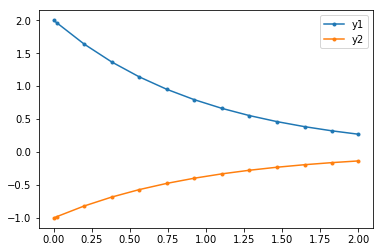

In [5]:
plt.plot(sol.t, sol.y[0], marker='.', label='y1')
plt.plot(sol.t, sol.y[1], marker='.', label='y2')
plt.legend()

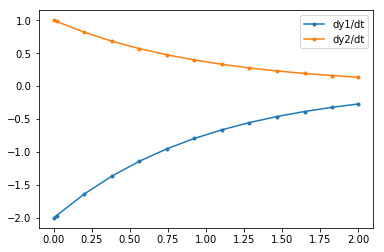

In [6]:
plt.plot(sol.t, f(sol.t, sol.y)[0], marker='.', label='dy1/dt')
plt.plot(sol.t, f(sol.t, sol.y)[1], marker='.', label='dy2/dt')
plt.legend()

# Build NN

In [7]:
t = np.linspace(0, 2.0, 11).reshape(-1,1) # training points

In [8]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params1 = init_weights()
params2 = init_weights()
params_list = [params1, params2]
print([ p.shape for p in params1 ])

[(1, 10), (10,), (10, 1), (1,)]


In [9]:
[init_weights() for _ in range(3)]

[[array([[-0.90549179, -0.81576476, -1.16130766,  1.43630608, -1.60039716,
          -0.54912199, -2.08979072, -1.36526925,  2.37750209, -0.90665596]]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([[ 0.79777695],
         [ 0.96277719],
         [ 1.08337977],
         [-1.09650262],
         [-1.46155025],
         [ 1.54081007],
         [-0.12201834],
         [ 1.33587834],
         [ 0.25962151],
         [-1.33537121]]),
  array([ 0.])],
 [array([[ 0.64857613, -0.7592072 , -0.3389917 , -0.19505624,  0.41429068,
           0.0786581 ,  0.41942054,  1.62315181,  0.89856314, -0.5100915 ]]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([[-0.04813994],
         [ 2.04705042],
         [-1.17343981],
         [ 1.27385501],
         [ 0.44971517],
         [ 0.47728238],
         [ 0.94901337],
         [ 2.48873634],
         [-0.56369993],
         [ 0.93915398]]),
  array([ 0.])],
 [array([[ 0.28684624,  1.80668512, -1.59187849, -0.64

In [10]:
def predict(params, t, y0, act=np.tanh):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(t, W1) + b1)
    y = np.dot(a, W2) + b2
    
    phi = y0 + t*y
    
    return phi

In [11]:
predict(params1, t, y0_list[1]).shape # vectorized over t

(11, 1)

In [12]:
predict_dt = egrad(predict, argnum=1) # element-wise grad w.r.t t, 

In [13]:
predict_dt(params1, t, y0_list[1]).shape

(11, 1)

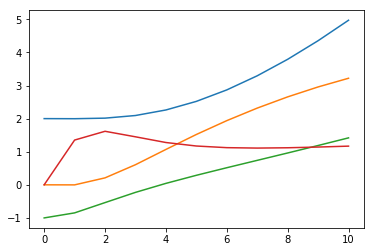

In [14]:
plt.plot(predict(params1, t, y0_list[0]))
plt.plot(predict_dt(params1, t, y0_list[0]))
plt.plot(predict(params2, t, y0_list[1]))
plt.plot(predict_dt(params2, t, y0_list[1]))

In [15]:
def loss_func(params_list, t, y0_list):
    
    
    y_pred_list = []
    dydt_pred_list = []
    for params, y0 in zip(params_list, y0_list):
        y_pred =  predict(params, t, y0)
        dydt_pred = predict_dt(params, t, y0)
        
        y_pred_list.append(y_pred.squeeze())
        dydt_pred_list.append(dydt_pred.squeeze())
        
    f_pred_list = f(t, y_pred_list)
    
    loss_total = 0.0
    for f_pred, dydt_pred in zip(f_pred_list, dydt_pred_list):
        loss = np.sum( (dydt_pred-f_pred)**2 )
        loss_total += loss
    
    return loss_total 

In [16]:
loss_func(params_list, t, y0_list)

390269973.51383567

In [17]:
flattened_params, unflat_func = flatten(params_list)

In [18]:
def loss_part(flattened_params):
    '''make partial function. 
    Use this simple method because
    autograd or scipy does not like functool.partial'''
    
    params_list = unflat_func(flattened_params) # recover
    
    # warning: global t and y0 are used
    return loss_func(params_list, t, y0_list)

In [19]:
loss_part(flattened_params)

390269973.51383567

In [20]:
loss_part_grad = grad(loss_part)

In [21]:
loss_part_grad(flattened_params).shape

(62,)

In [22]:
%%time
count = 0
def print_loss(x):
    global count
    if count %200 == 0:  
        print("iteration:", count, "loss: ", loss_part(x))
    count += 1
        
o = minimize(loss_part, x0=flattened_params, jac=loss_part_grad, 
             method="BFGS", callback=print_loss, 
             options = {'disp': True, 'maxiter': 1000})

iteration: 0 loss:  870901.92154
iteration: 200 loss:  0.0137274292096
iteration: 400 loss:  0.00073221316305
iteration: 600 loss:  0.000279089251664
iteration: 800 loss:  0.000157879135229
         Current function value: 0.000140
         Iterations: 932
         Function evaluations: 1098
         Gradient evaluations: 1086
CPU times: user 6.55 s, sys: 61.4 ms, total: 6.61 s
Wall time: 6.7 s


In [23]:
loss_part(o.x)

0.00013998378863202881

In [24]:
print(o.fun, o.njev, o.nfev, '\n', o.message)

0.0001399837886320288 1086 1098 
 Desired error not necessarily achieved due to precision loss.


In [25]:
params1_opt, params2_opt = unflat_func(o.x)

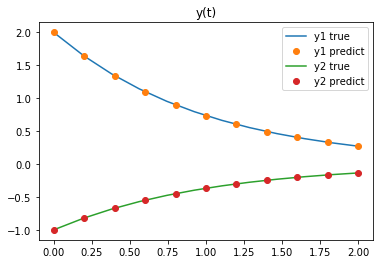

In [26]:
plt.plot(sol.t, sol.y[0], label='y1 true')
plt.plot(t, predict(params1_opt, t, y0_list[0]), 'o', label='y1 predict')

plt.plot(sol.t, sol.y[1], label='y2 true')
plt.plot(t, predict(params2_opt, t, y0_list[1]), 'o', label='y2 predict')

plt.legend()
plt.title('y(t)')

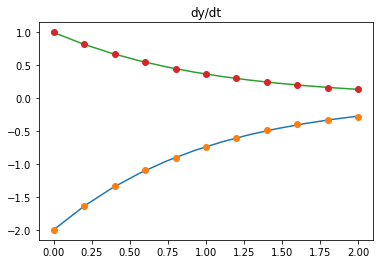

In [27]:
plt.plot(sol.t, f(sol.t, sol.y)[0])
plt.plot(t, predict_dt(params1_opt, t, y0_list[0]), 'o')

plt.plot(sol.t, f(sol.t, sol.y)[1])
plt.plot(t, predict_dt(params2_opt, t, y0_list[1]), 'o')

plt.title('dy/dt')